In [4]:
import gzip
import json
import pickle


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename, "r") as f:
        data = json.load(f)
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")

    return df

In [48]:
def wrangle(filename):
    # Read CSV file
    df = pd.read_csv(filename)
    
    #df['Purchase_DATE']= df['Purchase_DATE'].astype(float)
    
    df["Purchase_DATE"] = df['Purchase_DATE'].str.replace('.', '', regex=False).astype(float)
    
    return df

In [49]:
df = wrangle(r"C:\Users\sanus\Desktop\DS\web\Online Shop Customer Sales Data.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65796 entries, 0 to 65795
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Customer_id     65796 non-null  int64  
 1   Age             65796 non-null  int64  
 2   Gender          65796 non-null  int64  
 3   Revenue_Total   65796 non-null  float64
 4   N_Purchases     65796 non-null  int64  
 5   Purchase_DATE   65796 non-null  float64
 6   Purchase_VALUE  65796 non-null  float64
 7   Pay_Method      65796 non-null  int64  
 8   Time_Spent      65796 non-null  int64  
 9   Browser         65796 non-null  int64  
 10  Newsletter      65796 non-null  int64  
 11  Voucher         65796 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 6.0 MB
None


,Customer_id,Age,Gender,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
0,504308,53,0,45.3,2,220621.0,24.915,1,885,0,0,0
1,504309,18,1,36.2,3,101221.0,2.896,2,656,0,0,1
2,504310,52,1,10.6,1,140321.0,10.600,0,761,0,1,0
3,504311,29,0,54.1,5,251021.0,43.280,1,906,0,1,0
4,504312,21,1,56.9,1,140921.0,56.900,1,605,0,1,0


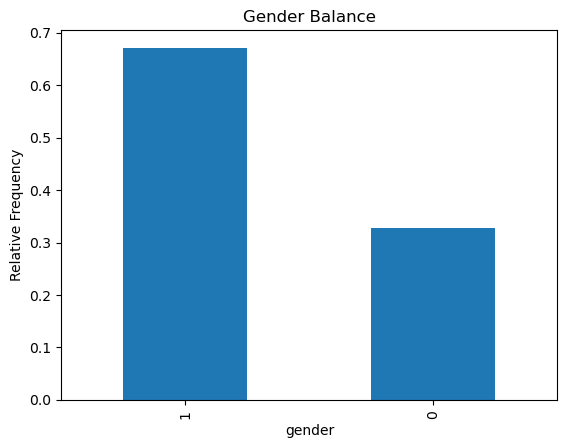

In [50]:
# Plot value counts of `"Gender"`
df["Gender"].value_counts(normalize=True).plot(
    kind="bar", xlabel="gender", ylabel="Relative Frequency", title="Gender Balance"
);

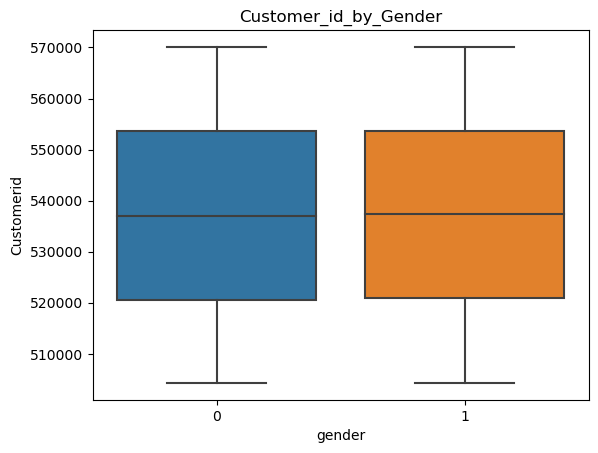

In [51]:
# Create boxplot
sns.boxplot(x="Gender", y="Customer_id", data=df)
plt.xlabel("gender")
plt.ylabel("Customerid")
plt.title("Customer_id_by_Gender");

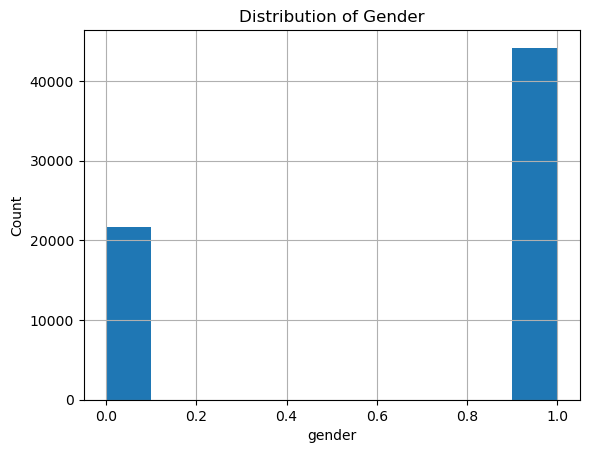

In [52]:
# Plot histogram of `Gender`
df["Gender"].hist()
plt.xlabel("gender")
plt.ylabel("Count"),
plt.title("Distribution of Gender");

Plot a correlation heatmap of features in df. Since "bankrupt" will be your target, you don't need to include it in your heatmap.

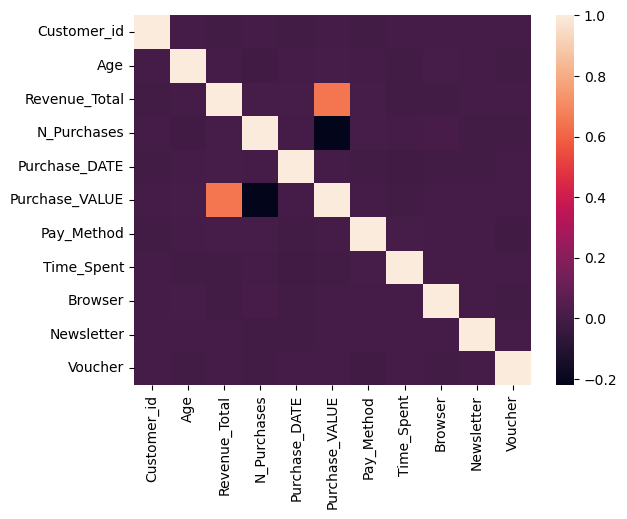

In [53]:
corr = df.drop(columns="Gender").corr()
sns.heatmap(corr);

So what did we learn from this EDA? First, our data is imbalanced. This is something we need to address in our data preparation. Second, many of our features have missing values that we'll need to impute. And since the features are highly skewed, the best imputation strategy is likely median, not mean. Finally, we have autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

# Split

So let's start building that model. If you need a refresher on how and why we split data in these situations, take a look back at the Time Series module.

Task 5.2.10: Create your feature matrix X and target vector y. Your target is "bankrupt".

In [54]:
target = "Gender"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (65796, 11)
y shape: (65796,)


In order to make sure that our model can generalize, we need to put aside a test set that we'll use to evaluate our model once it's trained.

Task 5.2.11: Divide your data (X and y) into training and test sets using a randomized train-test split. Your validation set should be 20% of your total data. And don't forget to set a random_state for reproducibility.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (52636, 11)
y_train shape: (52636,)
X_test shape: (13160, 11)
y_test shape: (13160,)


Note that if we wanted to tune any hyperparameters for our model, we'd do another split here, further dividing the training set into training and validation sets. However, we're going to leave hyperparameters for the next lesson, so no need to do the extra split now

# Resample

Now that we've split our data into training and validation sets, we can address the class imbalance we saw during our EDA. One strategy is to resample the training data. (This will be different than the resampling we did with time series data in Project 3.) There are many to do this, so let's start with under-sampling

In [56]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(34672, 11)


,Customer_id,Age,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
0,520592,41,55.5,5,310721.0,4.995,0,991,3,0,1
1,520020,50,11.1,7,150521.0,2.331,1,668,1,0,0
2,512345,46,23.4,3,50521.0,20.124,0,511,2,0,0
3,554933,23,53.5,5,200821.0,14.445,1,959,0,1,0
4,569957,43,22.8,4,280321.0,17.784,2,1047,0,0,1


In [57]:
y_train_under.value_counts(normalize=True)

0    0.5
1    0.5
Name: Gender, dtype: float64

In [58]:
#Create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on your training data.
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

(70600, 11)


,Customer_id,Age,Revenue_Total,N_Purchases,Purchase_DATE,Purchase_VALUE,Pay_Method,Time_Spent,Browser,Newsletter,Voucher
0,520592,41,55.5,5,310721.0,4.995,0,991,3,0,1
1,534473,19,35.7,4,100121.0,15.351,2,757,0,0,1
2,526687,39,10.7,6,251021.0,6.955,0,1010,0,0,0
3,555318,50,50.9,6,150921.0,15.779,1,253,3,0,1
4,565288,31,5.8,6,171121.0,1.276,3,329,0,0,0


In [59]:
y_train_over.value_counts(normalize=True)

0    0.5
1    0.5
Name: Gender, dtype: float64

# Build Model
2.1. Baseline

As always, we need to establish the baseline for our model. Since this is a classification problem, we'll use accuracy score

In [60]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.6706


Note here that, because our classes are imbalanced, the baseline accuracy is very high. We should keep this in mind because, even if our trained model gets a high validation accuracy score, that doesn't mean it's actually good.Create three identical models: model_reg, model_under and model_over. All of them should use a SimpleImputer followed by a DecisionTreeClassifier. Train model_reg using the unaltered training data. For model_under, use the undersampled data. For model_over, use the oversampled data.

In [61]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
    
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
    
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over = make_pipeline(
    SimpleImputer(strategy="median"), DecisionTreeClassifier(random_state=42)
    
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

# Evaluate

In [62]:
# Calculate training and test accuracy for your three models
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train, y_train)
    acc_test = m.score(X_test, y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.5568
Training Accuracy: 0.8295
Test Accuracy: 0.5025
Training Accuracy: 1.0
Test Accuracy: 0.552


As we mentioned earlier, "good" accuracy scores don't tell us much about the model's performance when dealing with imbalanced data. So instead of looking at what the model got right or wrong, let's see how its predictions differ for the two classes in the dataset.

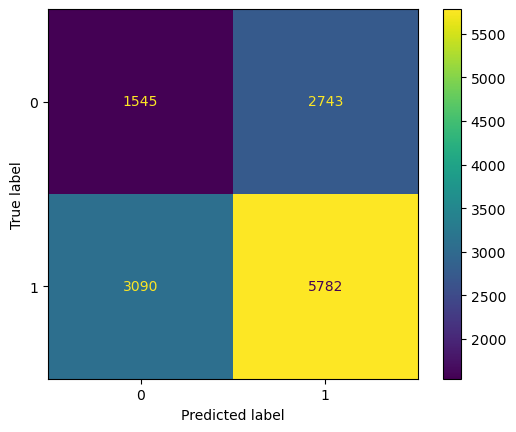

In [63]:
# Plot a confusion matrix that shows how your best model performs on your validation set
ConfusionMatrixDisplay.from_estimator(model_reg, X_test, y_test);

In [64]:
# Determine the depth of the decision tree in model_over
depth = model_over.named_steps["decisiontreeclassifier"].get_depth()
print(depth)

62


# Communicate
Now that we have a reasonable model, let's graph the importance of each feature

Create a horizontal bar chart with the 15 most important features for model_over. Be sure to label your x-axis "Gini Importance".

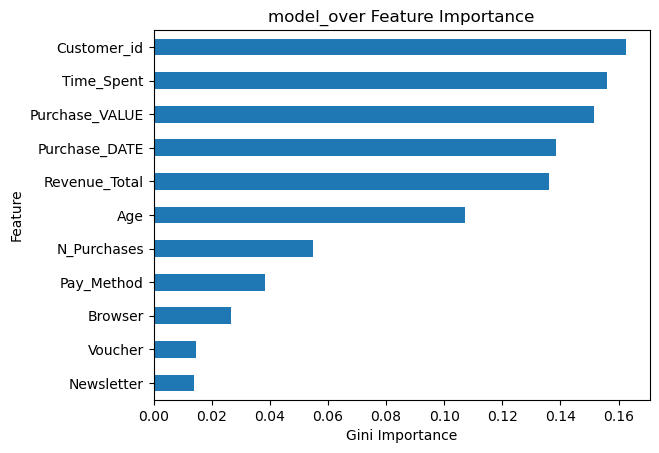

In [65]:
# Get importances
importances = model_over.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp =  pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

In [66]:
# Save your model as `"model-5-2.pkl"`
with open("model-5-2.pkl", "wb") as f:
    pickle.dump(model_over, f)

In [67]:
# Load `"model-5-2.pkl"`
with open("model-5-2.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print(loaded_model)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])
